In [ ]:
!pip install torch transformers datasets --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from datasets import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from scipy.stats import pearsonr
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/dataset/MELD/train_sent_emo.csv'

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv(file_path)
df.head()


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [ ]:
text_df=df['Utterance']
text_df=pd.DataFrame(text_df)
text_df.head()

,Utterance
0,also I was the point person on my company’s tr...
1,You must’ve had your hands full.
2,That I did. That I did.
3,So let’s talk a little bit about your duties.
4,My duties? All right.


In [ ]:
assert 'Utterance' in df.columns and 'Emotion' in df.columns

# Labels encoding

In [ ]:
labels = sorted(df['Emotion'].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
df['label'] = df['Emotion'].map(label2id)

In [ ]:
# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df[['Utterance', 'label']].rename(columns={"Utterance": "text"}))
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize(example):
    return tokenizer(example['text'], padding="max_length", truncation=True, max_length=64)

dataset = dataset.map(tokenize)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Split into train/val
split = dataset.train_test_split(test_size=0.2, seed=42)
train_loader = DataLoader(split['train'], batch_size=32, shuffle=True)
val_loader = DataLoader(split['test'], batch_size=32)

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

# Text Encoder (BERT + BiGRU)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.bigru = nn.GRU(input_size=768, hidden_size=hidden_dim, num_layers=1,
                            bidirectional=True, batch_first=True)
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        gru_output, _ = self.bigru(bert_output)
        return gru_output

#  Module (Self-Attention + FFN)

In [ ]:
class FusionLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim), nn.ReLU(), nn.Linear(dim, dim))
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.ffn(x)
        return self.norm2(x + ff_output)


# BBFN Text

In [ ]:
class BBFNText(nn.Module):
    def __init__(self, hidden_dim=128, n_layers=2, num_classes=7):
        super().__init__()
        self.encoder = TextEncoder(hidden_dim)
        self.layers = nn.ModuleList([FusionLayer(hidden_dim*2) for _ in range(n_layers)])
        self.head = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.encoder(input_ids, attention_mask)
        for layer in self.layers:
            x = layer(x)
        x_cls = x[:, 0, :]
        return self.head(x_cls)

# Validation

In [ ]:
def validate(model, val_loader, device):
    from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
    from scipy.stats import pearsonr

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc7 = accuracy_score(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    acc2 = accuracy_score([1 if l > 0 else 0 for l in all_labels], [1 if p > 0 else 0 for p in all_preds])
    f1 = f1_score(all_labels, all_preds, average='weighted')
    corr, _ = pearsonr(all_labels, all_preds)
    return acc7, acc2, f1, mae, corr


# Training setup

In [ ]:
num_epochs = 10
batch_size = 32
learning_rate = 0.0001
optimizer_choice = 'Adam'
dropout_rate = 0.2

num_classes = len(label2id)
model = BBFNText(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if optimizer_choice == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_choice == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_choice}")
criterion = nn.CrossEntropyLoss()
history = {'acc7': [], 'acc2': [], 'f1': [], 'mae': [], 'corr': []}


# Training Loop


In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx+1}/{len(train_loader)}")
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation After Each Epoch
    acc7, acc2, f1, mae, corr = validate(model, val_loader, device)
    print(f"Epoch {epoch+1}")
    print(f"  Accuracy (Acc-7): {acc7:.4f}")
    print(f"  Accuracy (Acc-2): {acc2:.4f}")
    print(f"  F1 Score (weighted): {f1:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Pearson Correlation: {corr:.4f}")

    history['acc7'].append(acc7)
    history['acc2'].append(acc2)
    history['f1'].append(f1)
    history['mae'].append(mae)
    history['corr'].append(corr)

Epoch 1 | Batch 1/250
Epoch 1 | Batch 11/250
Epoch 1 | Batch 21/250
Epoch 1 | Batch 31/250
Epoch 1 | Batch 41/250
Epoch 1 | Batch 51/250
Epoch 1 | Batch 61/250
Epoch 1 | Batch 71/250
Epoch 1 | Batch 81/250
Epoch 1 | Batch 91/250
Epoch 1 | Batch 101/250
Epoch 1 | Batch 111/250
Epoch 1 | Batch 121/250
Epoch 1 | Batch 131/250
Epoch 1 | Batch 141/250
Epoch 1 | Batch 151/250
Epoch 1 | Batch 161/250
Epoch 1 | Batch 171/250
Epoch 1 | Batch 181/250
Epoch 1 | Batch 191/250
Epoch 1 | Batch 201/250
Epoch 1 | Batch 211/250
Epoch 1 | Batch 221/250
Epoch 1 | Batch 231/250
Epoch 1 | Batch 241/250
Epoch 1
  Accuracy (Acc-7): 0.5886
  Accuracy (Acc-2): 0.8874
  F1 Score (weighted): 0.5465
  Mean Absolute Error (MAE): 0.9419
  Pearson Correlation: 0.3116
Epoch 2 | Batch 1/250
Epoch 2 | Batch 11/250
Epoch 2 | Batch 21/250
Epoch 2 | Batch 31/250
Epoch 2 | Batch 41/250
Epoch 2 | Batch 51/250
Epoch 2 | Batch 61/250
Epoch 2 | Batch 71/250
Epoch 2 | Batch 81/250
Epoch 2 | Batch 91/250
Epoch 2 | Batch 101/250


# Plotting

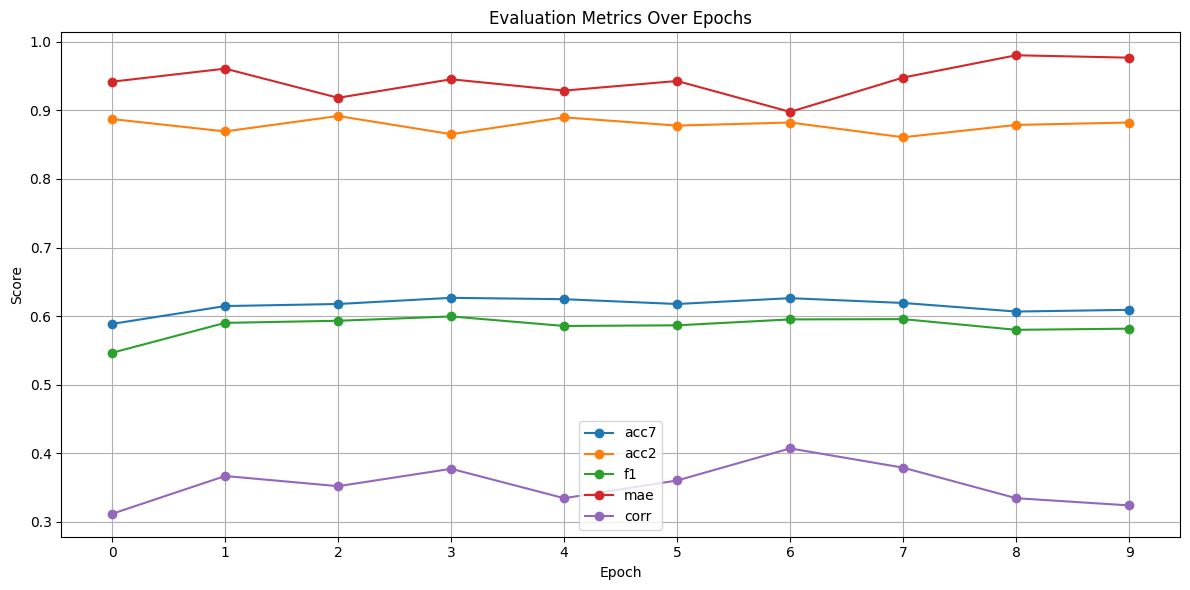

In [ ]:
def plot_metrics(history):
    metrics = ['acc7', 'acc2', 'f1', 'mae', 'corr']
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history[metric], marker='o', label=metric)
    plt.title('Evaluation Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.xticks(range(len(history[metrics[0]])))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(history)


In [ ]:

new_file_path = '/content/drive/MyDrive/dataset/MELD_Dyadic/train_sent_emo_dya.csv'
df_new = pd.read_csv(new_file_path)
assert 'Utterance' in df_new.columns and 'Emotion' in df_new.columns




In [ ]:
df_new.head()

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Old_Dialogue_ID,Old_Utterance_ID,Season,Episode,StartTime,EndTime
0,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,0,0,8,21,"00:16:16,059","00:16:21,731"
1,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,0,1,8,21,"00:16:21,940","00:16:23,442"
2,That I did. That I did.,Chandler,neutral,neutral,0,2,0,2,8,21,"00:16:23,442","00:16:26,389"
3,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,0,3,8,21,"00:16:26,820","00:16:29,572"
4,My duties? All right.,Chandler,surprise,positive,0,4,0,4,8,21,"00:16:34,452","00:16:40,917"


In [ ]:
print("Df 1:" ,len(df))
print("Df 2:", len(df_new) )

Df 1: 9989
Df 2: 12840


In [ ]:
df_new['label'] = df_new['Emotion'].map(label2id)

new_dataset = Dataset.from_pandas(df_new[['Utterance', 'label']].rename(columns={"Utterance": "text"}))
new_dataset = new_dataset.map(tokenize)
new_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

split_new = new_dataset.train_test_split(test_size=0.2, seed=42)
train_loader_new = DataLoader(split_new['train'], batch_size=batch_size, shuffle=True)
val_loader_new = DataLoader(split_new['test'], batch_size=batch_size)

Map:   0%|          | 0/12840 [00:00<?, ? examples/s]

In [ ]:
new_history = {'acc7': [], 'acc2': [], 'f1': [], 'mae': [], 'corr': []}

for epoch in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(train_loader_new):
        if batch_idx % 10 == 0:
            print(f"[New Data] Epoch {epoch+1} | Batch {batch_idx+1}/{len(train_loader_new)}")

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    acc7, acc2, f1, mae, corr = validate(model, val_loader_new, device)
    print(f"[New Data] Epoch {epoch+1}")
    print(f"  Accuracy (Acc-7): {acc7:.4f}")
    print(f"  Accuracy (Acc-2): {acc2:.4f}")
    print(f"  F1 Score (weighted): {f1:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Pearson Correlation: {corr:.4f}")
    new_history['acc7'].append(acc7)
    new_history['acc2'].append(acc2)
    new_history['f1'].append(f1)
    new_history['mae'].append(mae)
    new_history['corr'].append(corr)


[New Data] Epoch 1 | Batch 1/321
[New Data] Epoch 1 | Batch 11/321
[New Data] Epoch 1 | Batch 21/321
[New Data] Epoch 1 | Batch 31/321
[New Data] Epoch 1 | Batch 41/321
[New Data] Epoch 1 | Batch 51/321
[New Data] Epoch 1 | Batch 61/321
[New Data] Epoch 1 | Batch 71/321
[New Data] Epoch 1 | Batch 81/321
[New Data] Epoch 1 | Batch 91/321
[New Data] Epoch 1 | Batch 101/321
[New Data] Epoch 1 | Batch 111/321
[New Data] Epoch 1 | Batch 121/321
[New Data] Epoch 1 | Batch 131/321
[New Data] Epoch 1 | Batch 141/321
[New Data] Epoch 1 | Batch 151/321
[New Data] Epoch 1 | Batch 161/321
[New Data] Epoch 1 | Batch 171/321
[New Data] Epoch 1 | Batch 181/321
[New Data] Epoch 1 | Batch 191/321
[New Data] Epoch 1 | Batch 201/321
[New Data] Epoch 1 | Batch 211/321
[New Data] Epoch 1 | Batch 221/321
[New Data] Epoch 1 | Batch 231/321
[New Data] Epoch 1 | Batch 241/321
[New Data] Epoch 1 | Batch 251/321
[New Data] Epoch 1 | Batch 261/321
[New Data] Epoch 1 | Batch 271/321
[New Data] Epoch 1 | Batch 281/

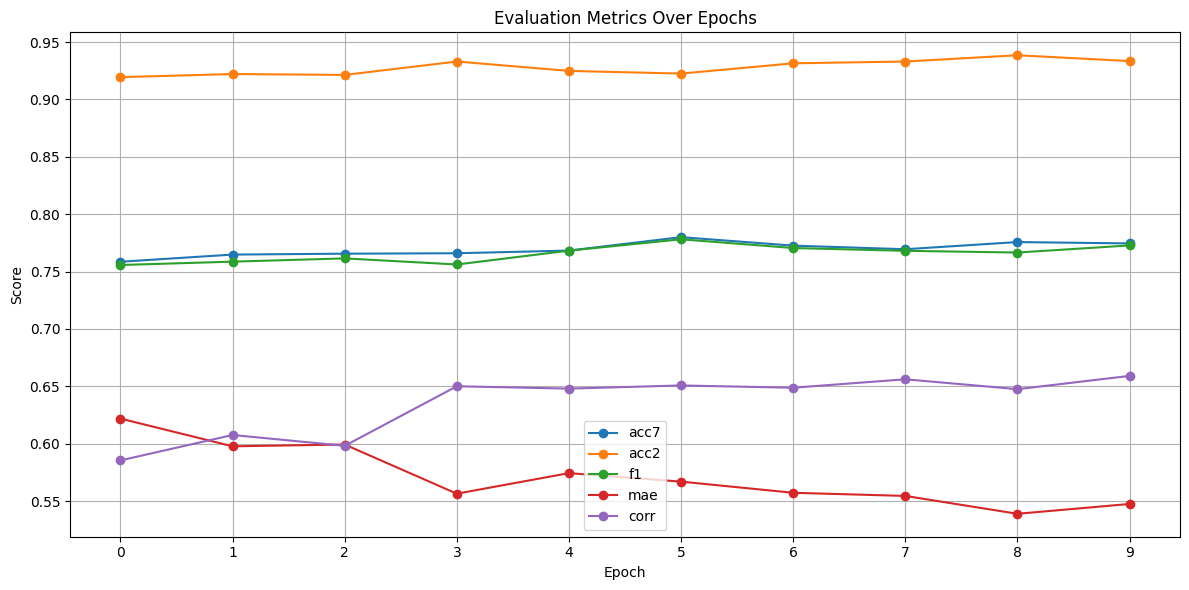

In [ ]:
plot_metrics(new_history)

# Bảng so sánh giữa 2 bộ data

In [ ]:
comparison_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Original_Acc7': history['acc7'],
    'New_Acc7': new_history['acc7'],
    'Original_Acc2': history['acc2'],
    'New_Acc2': new_history['acc2'],
    'Original_F1': history['f1'],
    'New_F1': new_history['f1'],
    'Original_MAE': history['mae'],
    'New_MAE': new_history['mae'],
    'Original_Corr': history['corr'],
    'New_Corr': new_history['corr']
})
print(" 📊 Comparison Table:")
display(comparison_df)


 📊 Comparison Table:


,Epoch,Original_Acc7,New_Acc7,Original_Acc2,New_Acc2,Original_F1,New_F1,Original_MAE,New_MAE,Original_Corr,New_Corr
0,1,0.588589,0.758567,0.887387,0.919393,0.546461,0.755712,0.941942,0.621885,0.311565,0.585473
1,2,0.614615,0.764798,0.869369,0.922118,0.590100,0.758642,0.960961,0.597741,0.366690,0.607600
2,3,0.617618,0.765576,0.891892,0.921340,0.593164,0.761470,0.918418,0.599299,0.351855,0.598175
3,4,0.626627,0.765966,0.865365,0.933022,0.599464,0.756178,0.945445,0.556464,0.377212,0.650072
4,5,0.624625,0.768302,0.889890,0.924844,0.585565,0.768226,0.928929,0.574377,0.334289,0.648012
5,6,0.617618,0.779984,0.877878,0.922508,0.586515,0.778125,0.942943,0.566978,0.360155,0.650768
6,7,0.626126,0.772586,0.882382,0.931464,0.595142,0.770513,0.897898,0.557243,0.406941,0.648791
7,8,0.619119,0.769470,0.860861,0.933022,0.595548,0.768071,0.947948,0.554517,0.378861,0.656133
8,9,0.606607,0.775701,0.878879,0.938474,0.579929,0.766584,0.980480,0.538941,0.334313,0.647532
9,10,0.609109,0.774533,0.882382,0.933411,0.581652,0.772769,0.976977,0.547508,0.323811,0.659090
